In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, Conv1D, MaxPooling1D, Flatten, Bidirectional

In [2]:
# Load the datasets
gold_price_data = pd.read_csv('dataset/ADANIENT.NS.csv')


# Display the first few rows of each dataset to understand their structure
print("Gold Price Data:")
print(gold_price_data.head())



Gold Price Data:
         Date      Open      High       Low     Close  Adj Close     Volume
0  2002-07-01  1.364148  1.401700  1.334259  1.362615  -0.010452  1080397.0
1  2002-07-02  1.386372  1.390971  1.356484  1.373344  -0.010535  1016147.0
2  2002-07-03  1.371811  1.387139  1.364914  1.373344  -0.010535   980394.0
3  2002-07-04  1.379475  1.401700  1.379475  1.381008  -0.010593   972747.0
4  2002-07-05  1.388672  1.388672  1.372578  1.377942  -0.010570   974496.0


In [3]:
# Preprocessing
gold_price_data.isna().sum().sum()
gold_price_data.dropna(inplace=True)

gold_price_data['Date'] = pd.to_datetime(gold_price_data['Date'])
gold_price_data.set_index('Date', inplace=True)
gold_price_data = gold_price_data.sort_index()

# Use only the 'Close' price for prediction
data = gold_price_data['Close'].values
data = data.reshape(-1, 1)

In [4]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [5]:
def create_dataset(data, window_size=1):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        a = data[i:(i + window_size), 0]
        X.append(a)
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

In [6]:
window_size = 60  # You can adjust this window size
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

In [7]:
# Reshape input to be [samples, time steps, features] for LSTM/RNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [25]:
# Bidirectional LSTM model
model_bi_lstm = Sequential()
model_bi_lstm.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(window_size, 1))))
model_bi_lstm.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model_bi_lstm.add(Dense(units=25))
model_bi_lstm.add(Dense(units=1))
model_bi_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_bi_lstm.fit(X_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
4279/4279 [==============================] - 62s 13ms/step - loss: 7.5925e-06
Epoch 2/2
4279/4279 [==============================] - 58s 14ms/step - loss: 2.5567e-06


In [26]:
# RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=50, return_sequences=True, input_shape=(window_size, 1)))
model_rnn.add(SimpleRNN(units=50, return_sequences=False))
model_rnn.add(Dense(units=25))
model_rnn.add(Dense(units=1))

model_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_rnn.fit(X_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
4279/4279 [==============================] - 34s 8ms/step - loss: 8.5740e-05
Epoch 2/2
4279/4279 [==============================] - 33s 8ms/step - loss: 4.7286e-06


In [37]:
# CNN model
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(units=50))
model_cnn.add(Dense(units=1))

model_cnn.compile(optimizer='adam', loss='mean_squared_error')

model_cnn.fit(X_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
4279/4279 [==============================] - 5s 1ms/step - loss: 9.4670e-06
Epoch 2/2
4279/4279 [==============================] - 4s 977us/step - loss: 4.2146e-06


In [28]:
# Function to predict and inverse transform the data
def predict_and_inverse_transform(model, X, y):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(predictions)
    y = scaler.inverse_transform([y])
    return predictions, y

In [29]:
# Predict using Bidirectional LSTM
predictions_bi_lstm, y_test_bi_lstm = predict_and_inverse_transform(model_bi_lstm, X_test, y_test)

# Predict using RNN
predictions_rnn, y_test_rnn = predict_and_inverse_transform(model_rnn, X_test, y_test)

# Predict using CNN
predictions_cnn, y_test_cnn = predict_and_inverse_transform(model_cnn, X_test, y_test)

33/33 [==============================] - 0s 972us/step


In [30]:
# Calculate MAE and MSE
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_bi_lstm = mean_absolute_error(y_test_bi_lstm[0], predictions_bi_lstm)
mse_bi_lstm = mean_squared_error(y_test_bi_lstm[0], predictions_bi_lstm)

mae_rnn = mean_absolute_error(y_test_rnn[0], predictions_rnn)
mse_rnn = mean_squared_error(y_test_rnn[0], predictions_rnn)

mae_cnn = mean_absolute_error(y_test_cnn[0], predictions_cnn)
mse_cnn = mean_squared_error(y_test_cnn[0], predictions_cnn)

In [31]:
# Print MAE and MSE
print(f'Bidirectional LSTM - MAE: {mae_bi_lstm}, MSE: {mse_bi_lstm}')
print(f'RNN - MAE: {mae_rnn}, MSE: {mse_rnn}')
print(f'CNN - MAE: {mae_cnn}, MSE: {mse_cnn}')

Bidirectional LSTM - MAE: 140.07648164305738, MSE: 53179.65827332652
RNN - MAE: 97.2679214193107, MSE: 26328.81830559721
CNN - MAE: 253.9452728981317, MSE: 114562.72254462447


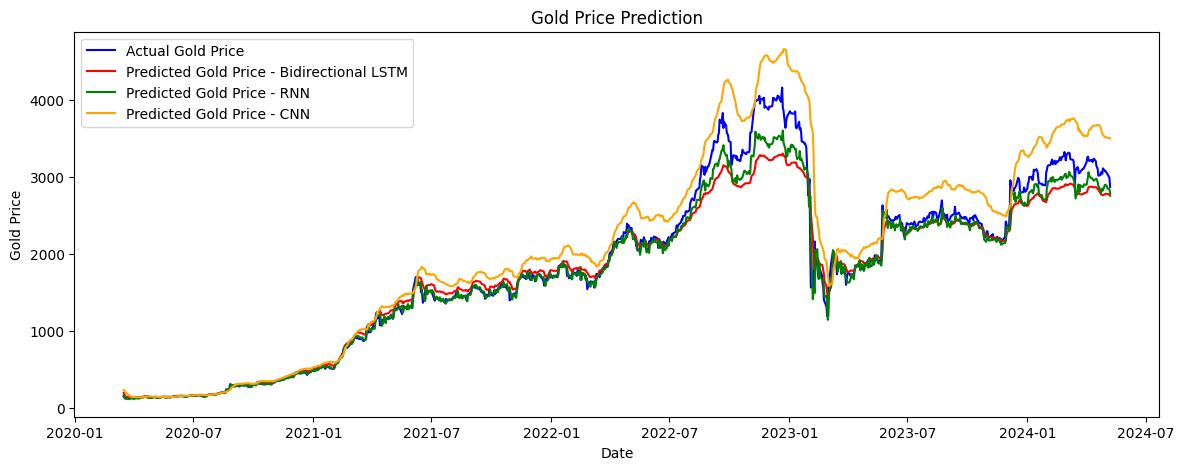

In [32]:
plt.figure(figsize=(14, 5))
plt.plot(gold_price_data.index[train_size+window_size+1:], y_test_bi_lstm[0], color='blue', label='Actual Gold Price')
plt.plot(gold_price_data.index[train_size+window_size+1:], predictions_bi_lstm, color='red', label='Predicted Gold Price - Bidirectional LSTM')
plt.plot(gold_price_data.index[train_size+window_size+1:], predictions_rnn, color='green', label='Predicted Gold Price - RNN')
plt.plot(gold_price_data.index[train_size+window_size+1:], predictions_cnn, color='orange', label='Predicted Gold Price - CNN')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price Prediction')
plt.legend()
plt.show()